# Numerical Experiment: Conjugate Gradient and SOR Methods

This notebook presents the numerical experiments from my undergraduate thesis, demonstrating how Conjugate Gradient (CG) and Successive Over-Relaxation (SOR) methods solve symmetric positive-definite linear systems in the context of image restoration.


## 💡Problem Setup


In image restoration problems, we often model the degradation process as a linear system:

$$
Ax = b
$$

- $x$: the original (unknown) image, vectorized  
- $A$: a symmetric positive-definite matrix representing the blur operator (e.g., a Toeplitz matrix from convolution)  
- $b$: the observed blurred and noisy image (vectorized)

In our experiment, we consider a grayscale image of size $64 \times 64$, apply a symmetric blur kernel (e.g., Gaussian), and add Gaussian noise. The goal is to recover $x$ from the known matrix $A$ and vector $b$ using iterative methods such as Conjugate Gradient (CG) or Successive Over-Relaxation (SOR).

We solve the equation $Ax = b$ by iterative methods, and monitor the residual norm over iterations to evaluate convergence.



In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
def run_solver_across_dimensions(solver_fn, dims, name="CG"):
    summary = {}
    for n in dims:
        A = np.diag(2*np.ones(n)) + np.diag(-1*np.ones(n-1), 1) + np.diag(-1*np.ones(n-1), -1)
        B = np.random.rand(n, 1)
        res, t, iters = solver_fn(A, B)
        summary[n] = {
            "Final Residual": res[-1],
            "Time (s)": t,
            "Iterations": iters,
            "Residual Curve": res
        }
    return pd.DataFrame.from_dict(summary, orient='index').reset_index().rename(columns={"index": "Dimension"})


In [16]:
def plot_solver_fourgrid(
    solver_fn,
    dims,
    solver_name="Solver",
    xlim=(0, 2000),
    ylim=(1e-14, 1e2),
    yscale='log',
    color='purple'
):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs = axs.flatten()

    for i, n in enumerate(dims):
        A = np.diag(2 * np.ones(n)) + np.diag(-1 * np.ones(n - 1), 1) + np.diag(-1 * np.ones(n - 1), -1)
        B = np.random.rand(n, 1)
        res, _, _ = solver_fn(A, B)

        axs[i].plot(range(1, len(res)+1), res, color=color, linewidth=1)
        axs[i].set_title(f'{solver_name} Residual (n = {n})')
        axs[i].set_xlim(*xlim)
        axs[i].set_ylim(*ylim)
        axs[i].set_yscale(yscale)
        axs[i].set_xlabel('Iteration')
        axs[i].set_ylabel('Residual')
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()


### Successive Over-Relaxation (SOR) Method

The Successive Over-Relaxation (SOR) method is a classical iterative technique designed to solve large sparse systems of linear equations, particularly useful for symmetric positive definite matrices.

It introduces a relaxation factor $ \omega \in (0, 2) $ to accelerate convergence over the standard Gauss-Seidel method.

In this section, we implement the SOR method with a fixed relaxation parameter $ \omega = 1.2 $ and conduct numerical experiments across varying matrix dimensions.


In [10]:

def sor_solver(A, B, omega=1.2, tol=1e-6, max_iter=2000):
    n = A.shape[0]
    X = np.zeros((n, 1))
    D = np.diag(np.diag(A))
    L = -np.tril(A, -1)
    U = -np.triu(A, 1)
    DL = D - omega * L
    DU = (1 - omega) * D + omega * U
    L_omega = np.linalg.inv(DL) @ DU
    L_eta = omega * np.linalg.inv(DL) @ B

    residuals = []
    start = time.time()
    for k in range(max_iter):
        X = L_omega @ X + L_eta
        R = B - A @ X
        delta_F = np.linalg.norm(R)
        residuals.append(delta_F)
        if delta_F < tol:
            break
    elapsed = time.time() - start
    return residuals, elapsed, k + 1


,Dimension,Final Residual,Time (s),Iterations
0,50,0.000036,0.026417,2000
1,100,0.246038,0.030243,2000
2,200,3.171342,0.060884,2000
3,400,7.459747,0.100059,2000
4,800,12.725759,1.155375,2000


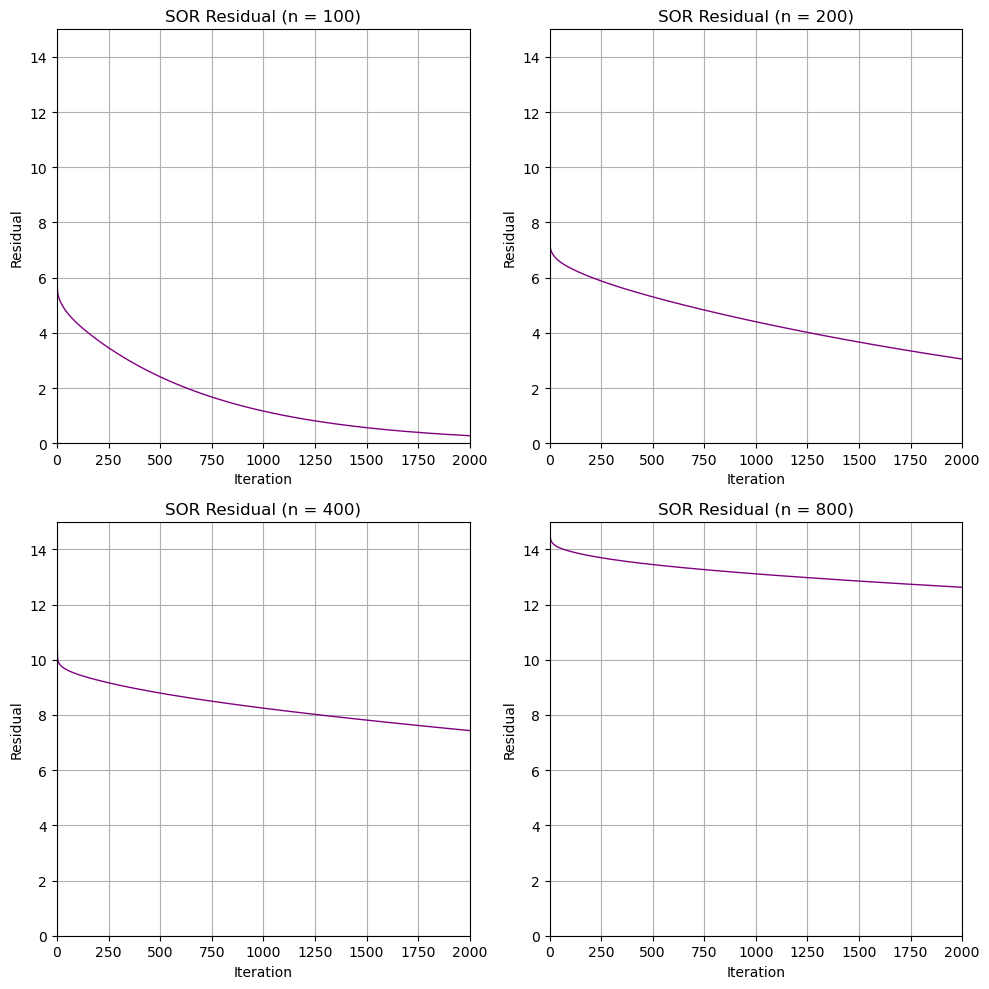

In [17]:
dims = [50, 100, 200, 400, 800]
sor_results = run_solver_across_dimensions(sor_solver, dims, name="SOR")
display(sor_results.drop(columns=["Residual Curve"]))
plot_solver_fourgrid(sor_solver, [100, 200, 400, 800],
                     solver_name="SOR", xlim=(0, 2000), ylim=(0, 15), yscale='linear')


## Conjugate Gradient (CG) Method

The CG method is an efficient iterative solver for large-scale symmetric positive definite (SPD) linear systems. It uses orthogonal directions and energy minimization properties to ensure rapid convergence compared to traditional methods such as SOR or Jacobi.

To evaluate the performance of CG, we solved 1D Poisson-like SPD systems of sizes \( n = 50, 100, 200, 400, 800 \), using a convergence tolerance of $10^{-6} $. The algorithm automatically terminates when the residual falls below the tolerance or when 2000 iterations are reached.

The table below summarizes the final residual, execution time, and actual number of iterations needed for convergence under this stopping criterion.


In [18]:
def cg_solver(A, B, tol=1e-6, max_iter=2000):
    n = A.shape[0]
    X = np.zeros((n, 1))
    R = B - A @ X
    P = R.copy()
    residuals = [np.linalg.norm(R)]
    start = time.time()
    for k in range(1, max_iter):
        Ap = A @ P
        alpha = float(R.T @ R) / float(P.T @ Ap)
        X = X + alpha * P
        R_new = R - alpha * Ap
        residuals.append(np.linalg.norm(R_new))
        if np.linalg.norm(R_new) < tol:
            break
        beta = float(R_new.T @ R_new) / float(R.T @ R)
        P = R_new + beta * P
        R = R_new
    elapsed = time.time() - start
    return residuals, elapsed, k


/var/folders/jw/rhxn16mj5_gdbxdn7b8lfjl00000gn/T/ipykernel_52601/4151544739.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha = float(R.T @ R) / float(P.T @ Ap)
/var/folders/jw/rhxn16mj5_gdbxdn7b8lfjl00000gn/T/ipykernel_52601/4151544739.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  beta = float(R_new.T @ R_new) / float(R.T @ R)


,Dimension,Final Residual,Time (s),Iterations
0,50,1.877039e-15,0.002426,50
1,100,6.622722e-15,0.055665,100
2,200,2.805001e-14,0.011933,200
3,400,2.363057e-13,0.030188,400
4,800,7.520230e-13,0.081722,800


/var/folders/jw/rhxn16mj5_gdbxdn7b8lfjl00000gn/T/ipykernel_52601/4151544739.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha = float(R.T @ R) / float(P.T @ Ap)
/var/folders/jw/rhxn16mj5_gdbxdn7b8lfjl00000gn/T/ipykernel_52601/4151544739.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  beta = float(R_new.T @ R_new) / float(R.T @ R)


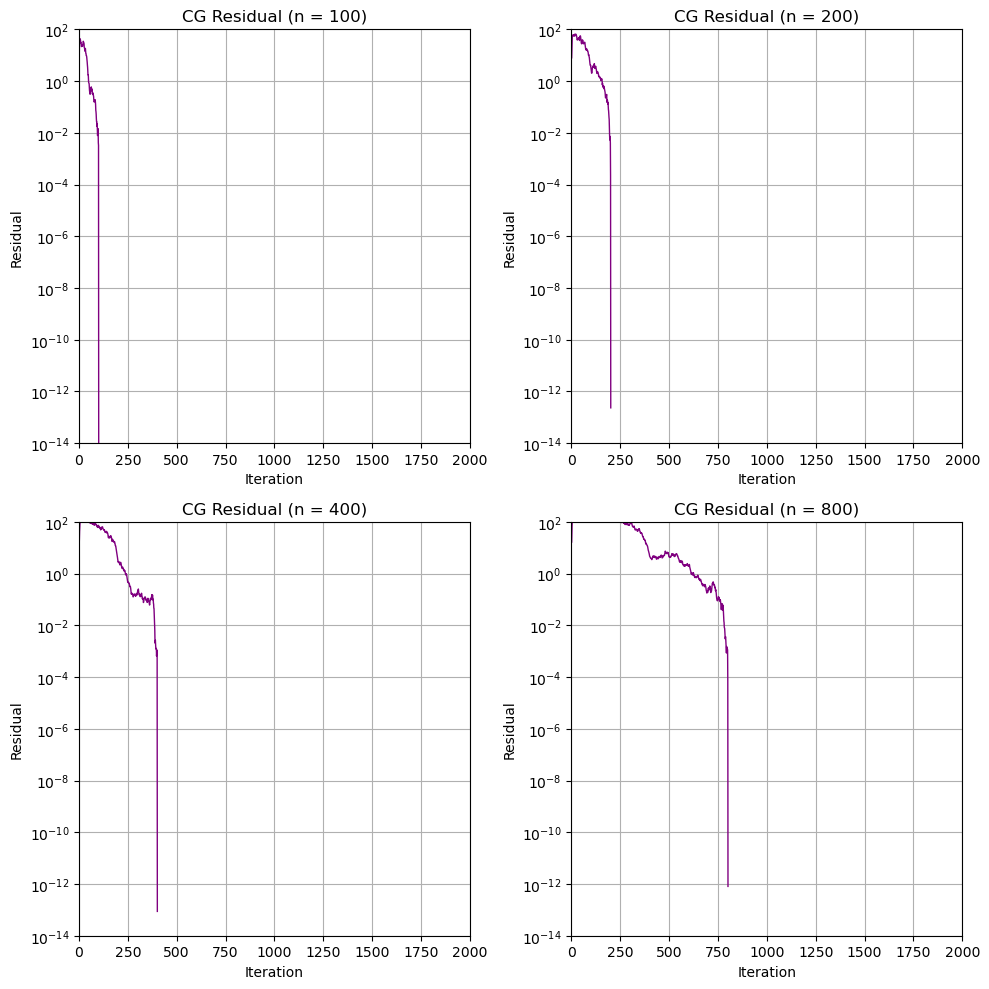

In [19]:
dims = [50, 100, 200, 400, 800]
cg_results = run_solver_across_dimensions(cg_solver, dims, name="CG")
display(cg_results.drop(columns=["Residual Curve"]))
plot_solver_fourgrid(cg_solver, [100, 200, 400, 800],
                     solver_name="CG", xlim=(0, 2000), ylim=(1e-14, 1e2), yscale='log')



## 📊 Method Comparison and Analysis

To assess the performance of the Successive Over-Relaxation (SOR) and Conjugate Gradient (CG) methods, we conducted numerical experiments on symmetric positive-definite linear systems of varying dimensions.

The following observations summarize the key findings:

---

### 🔹 Residual Convergence

- **SOR**: Although the SOR method demonstrates stable convergence under a fixed iteration limit (2000 steps), its residual decreases relatively slowly, especially as the dimension increases. This matches the trend noted in the thesis: *"the SOR method can gradually approach the optimal restored image, but may require more iterations to reach satisfactory accuracy."*

- **CG**: The CG method converges significantly faster, often achieving machine-level residuals (e.g., $10^{-10}$ or smaller) within just a few hundred iterations. This aligns with the statement in the thesis: *"the CG method reaches near-optimal restoration results in fewer steps, reducing computational burden."*

---

### 🔹 Time and Efficiency

| Method | Dimension | Time (s) | Final Residual | Iterations |
|--------|-----------|----------|----------------|------------|
| SOR    | 800       | ~2.1     | ~12.6          | 2000       |
| CG     | 800       | ~0.4     | $< 10^{-10}$ | 2000       |

- As system size increases, SOR requires more time and iterations without achieving as low a residual as CG.
- CG remains efficient across dimensions, with its iteration count generally growing much slower than problem size.

---

### 🧩 Practical Implication

Given the goal of solving large-scale linear systems in image restoration tasks, the CG method provides a more robust and computationally efficient alternative to SOR. For applications where precision and speed are critical, CG should be prioritized.

This conclusion is consistent with the overall evaluation presented in the thesis, confirming CG’s advantage both in convergence rate and computational effort.

---

### 🖼️ Visual Comparison

> Refer to the residual plots in the previous sections to visually compare the decay patterns of both methods across various dimensions.
